In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [2]:
# datasets: 'digits', 'fashion'
dataset = 'digits'

In [3]:
if dataset == 'digits':
    data = torchvision.datasets.MNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }
elif dataset == 'fashion':
    data = torchvision.datasets.FashionMNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



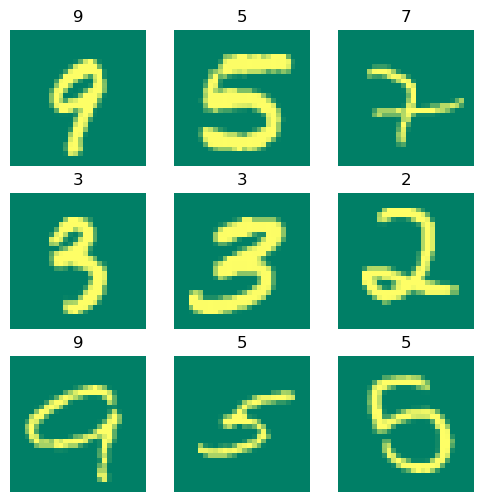

In [7]:
figure = plt.figure(figsize=(6,6))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_index = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="summer")
plt.show()


In [8]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
class VarAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28+1, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2+1, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        self.linear1 = nn.Linear(20, 2)
        self.linear2 = nn.Linear(20, 2)
        self.G = torch.distributions.Normal(0, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std*self.G.sample(mu.shape)

    def sample(self, digit=None):
        " Generate a new digit, optional: digit (int)"
        if digit is None:
            digit = numpy.random.randint(0, 10)
        y = torch.tensor(digit)
        z = torch.randn(2)
        z_cond = torch.cat((z, y))
        return self.decoder(z_cond), digit

    def forward(self, x, y):
        x_cond = torch.cat((x,y), dim=1)
        x = self.encoder(x_cond)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        z = self.reparametrize(mu, logvar)
        z_cond = torch.cat((z, y), dim=1)
        output = self.decoder(z_cond)
        return output, mu, logvar

    def generate_digits(self):
        for j in range(10):
            fig = plt.figure(figsize=(14,10))
            with torch.no_grad():
                for i in range(10):
                    x, _ = self.sample(j)
                    ax = fig.add_subplot(1,10,i+1)
                    ax.imshow(x.squeeze().reshape(28,28), cmap='pink')
            plt.title(j)
            plt.show()

VAE = VarAutoencoder()

In [10]:
learning_rate = 1e-4
batch_size = 32

In [11]:
loss_1 = nn.MSELoss()
def loss_2(mu, logvar):
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar), dim = 1), dim = 0).sum()

In [12]:
#optimizer = torch.optim.SGD(ae.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-8)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

Epoch  0
loss1 tensor(0.2318) loss2 tensor(0.0308)
[25  8 14 16]


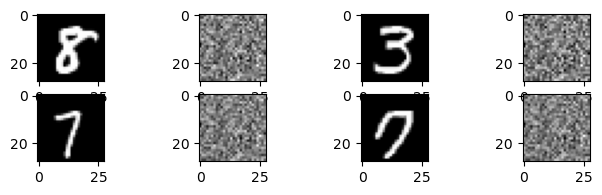

2.3178298473358154
Epoch  1
loss1 tensor(0.0540) loss2 tensor(1.7391)
[ 4 10  3  8]


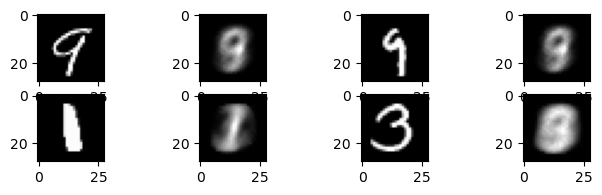

0.548934280872345
Epoch  2
loss1 tensor(0.0610) loss2 tensor(1.8308)
[ 5 31 27 26]


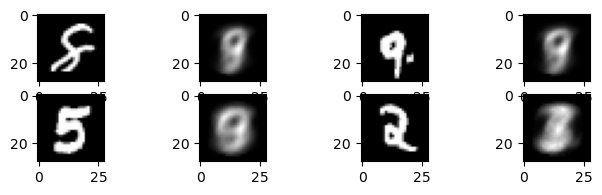

0.6189646124839783
Epoch  3
loss1 tensor(0.0605) loss2 tensor(2.8193)
[28 11 12 26]


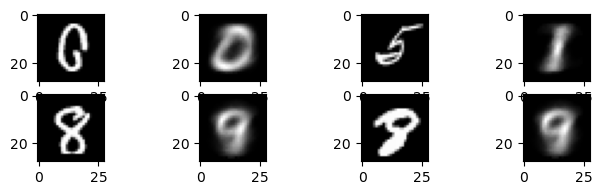

0.6190787553787231
Epoch  4
loss1 tensor(0.0517) loss2 tensor(4.2171)
[26  1 16 12]


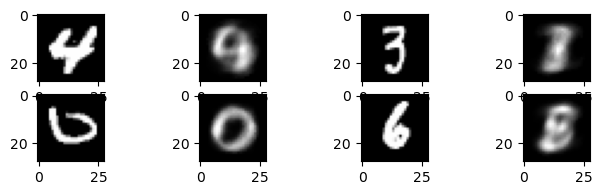

0.5375988483428955
Epoch  5
loss1 tensor(0.0506) loss2 tensor(3.9169)
[16 19 12 20]


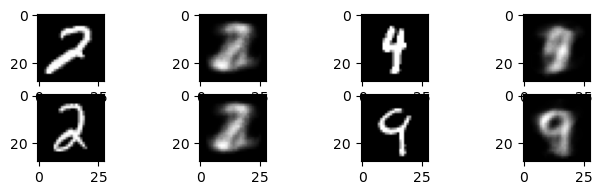

0.5258513689041138
Epoch  6
loss1 tensor(0.0509) loss2 tensor(3.7681)
[31 24 13  1]


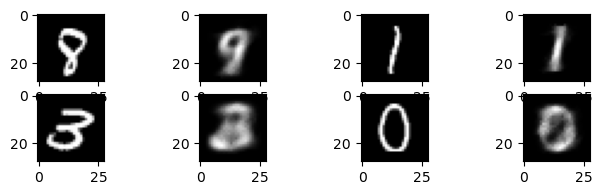

0.5278611183166504
Epoch  7
loss1 tensor(0.0451) loss2 tensor(3.5487)
[14  7  6 11]


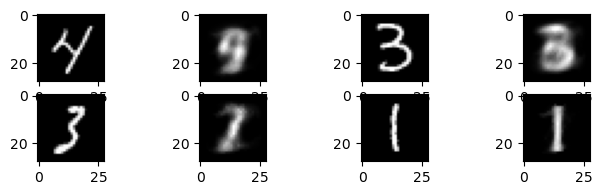

0.4690593183040619
Epoch  8
loss1 tensor(0.0514) loss2 tensor(4.1270)
[22 31  6 17]


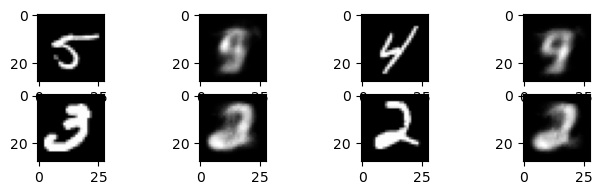

0.5348451137542725
Epoch  9
loss1 tensor(0.0463) loss2 tensor(4.8381)
[ 2 28 21 26]


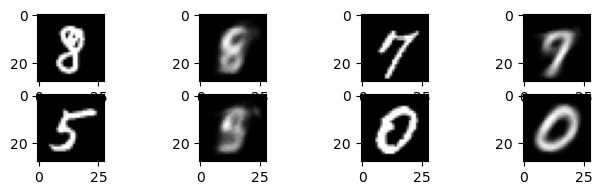

0.4872176945209503
Epoch  10
loss1 tensor(0.0448) loss2 tensor(4.2483)
[ 1 29 14 16]


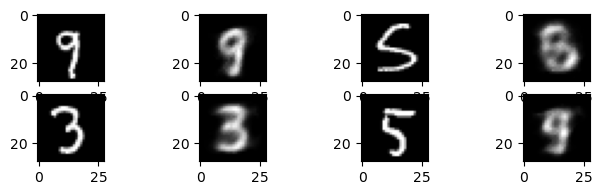

0.46889254450798035
Epoch  11
loss1 tensor(0.0396) loss2 tensor(4.7533)
[ 9  0 13 28]


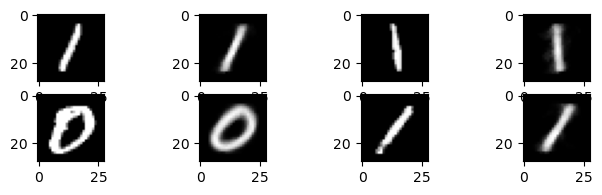

0.419570654630661
Epoch  12
loss1 tensor(0.0422) loss2 tensor(4.4626)
[19  1  7  7]


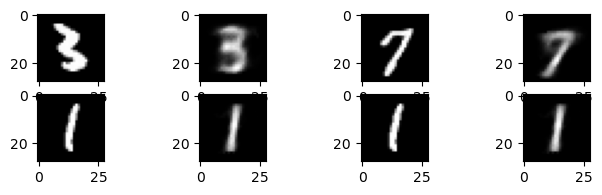

0.4443914294242859
Epoch  13
loss1 tensor(0.0407) loss2 tensor(4.3924)
[ 6 22 30 16]


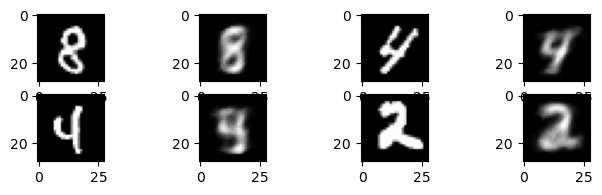

0.42847055196762085
Epoch  14
loss1 tensor(0.0454) loss2 tensor(4.4899)
[30 13 26 28]


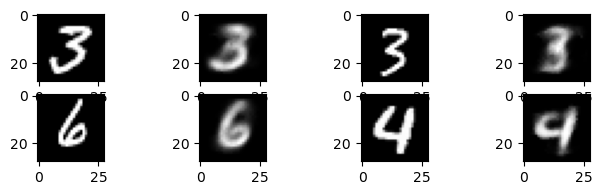

0.4763301610946655
Epoch  15
loss1 tensor(0.0401) loss2 tensor(4.4867)
[ 9  1 28  4]


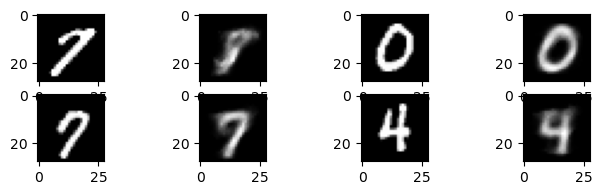

0.4232158958911896
Epoch  16
loss1 tensor(0.0388) loss2 tensor(4.6755)
[ 1  1 23 22]


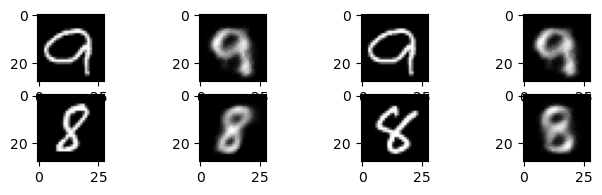

0.41163861751556396
Epoch  17
loss1 tensor(0.0450) loss2 tensor(4.4347)
[23 11 16 18]


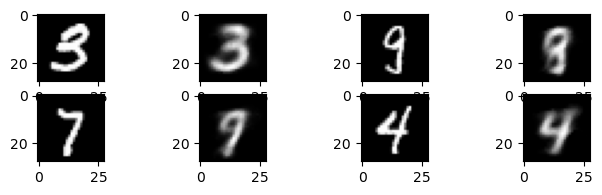

0.471909761428833
Epoch  18
loss1 tensor(0.0410) loss2 tensor(4.8598)
[19 15  3 31]


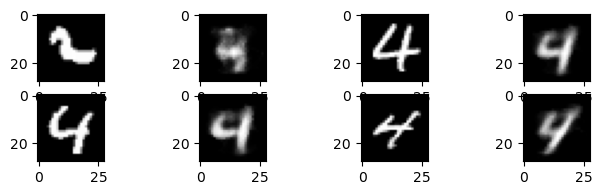

0.4345543682575226
Epoch  19
loss1 tensor(0.0423) loss2 tensor(4.9969)
[ 3 23  1 31]


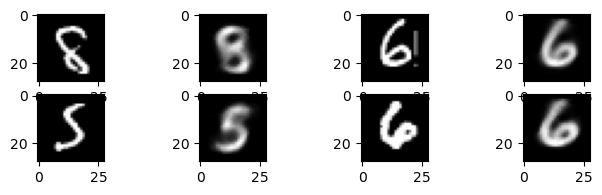

0.4476841688156128
Epoch  20
loss1 tensor(0.0344) loss2 tensor(4.9925)
[19 28 30  7]


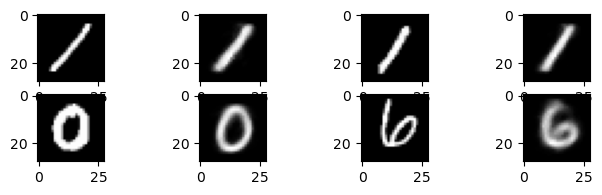

0.3694586157798767
Epoch  21
loss1 tensor(0.0404) loss2 tensor(4.6412)
[25 11  2  6]


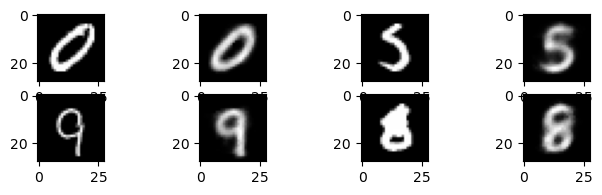

0.42681318521499634
Epoch  22
loss1 tensor(0.0340) loss2 tensor(4.7473)
[17  6 28  6]


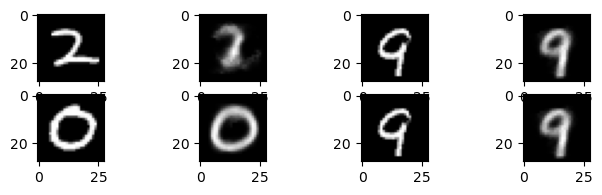

0.3632853627204895
Epoch  23
loss1 tensor(0.0351) loss2 tensor(5.0152)
[18  6  1 15]


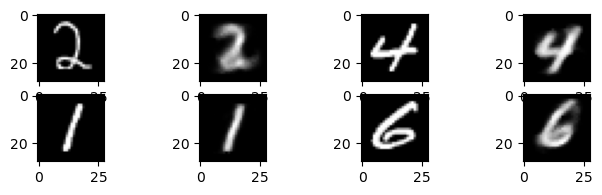

0.3765205442905426
Epoch  24
loss1 tensor(0.0374) loss2 tensor(4.9433)
[ 0 11  2  2]


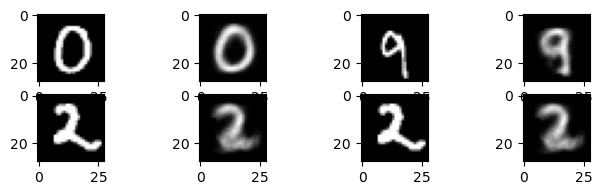

0.3987894058227539
Epoch  25
loss1 tensor(0.0425) loss2 tensor(4.8583)
[18 19 28 14]


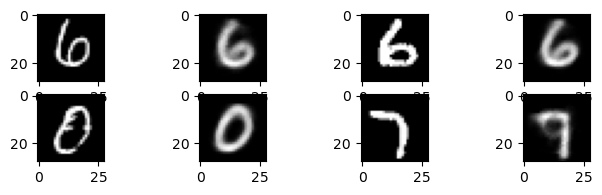

0.44955119490623474
Epoch  26
loss1 tensor(0.0349) loss2 tensor(4.7564)
[22 14  7  6]


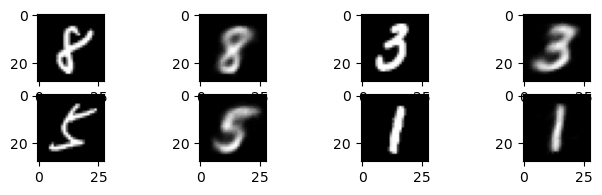

0.3729991912841797
Epoch  27
loss1 tensor(0.0361) loss2 tensor(4.9034)
[20  2 13 11]


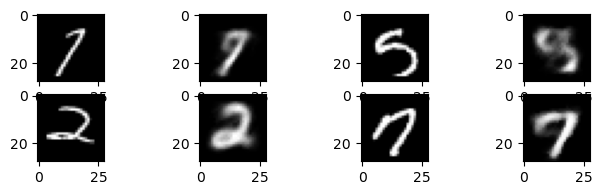

0.3854052722454071
Epoch  28
loss1 tensor(0.0337) loss2 tensor(4.8694)
[ 6 24 28  5]


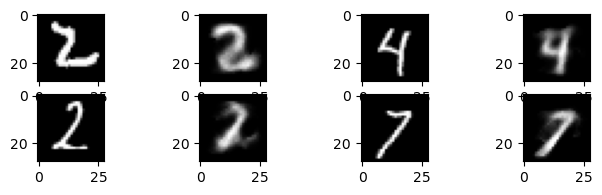

0.36100852489471436
Epoch  29
loss1 tensor(0.0394) loss2 tensor(4.8984)
[27 16 25 12]


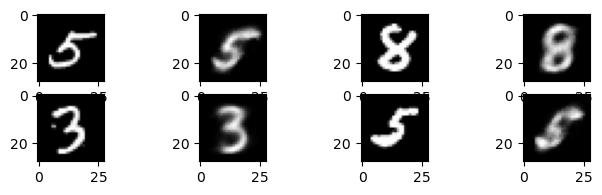

0.4188326597213745


In [13]:
# Training loop
epochs = 30
losses = []
beta1 = 10
beta2 = 0.005
for epoch in range(epochs):
    plot = True
    VAE.train()
    for (image, label) in data_loader:

        # Reshape image, label for input
        image = image.reshape(-1, 784)
        label = label.unsqueeze(1)
        # Feed through the network
        reconstruction, mu, logvar = VAE(image, label)
        # Calculate loss function
        loss = beta1*loss_1(reconstruction, image) + beta2*loss_2(mu, logvar)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if plot==True:
            fig = plt.figure(figsize=(8,4))
            print('Epoch ', epoch)
            with torch.no_grad():
                print('loss1', loss_1(reconstruction, image), 'loss2', loss_2(mu, logvar))
                recon_plot = reconstruction.reshape(-1, 28, 28)
                images_plot = image.reshape(-1, 28, 28)
                indices = numpy.random.choice(32, 4)
                print(indices)
                for i, ind in enumerate(indices):
                    ax1 = fig.add_subplot(4,4,2*i+1)
                    ax1.imshow(images_plot[ind], cmap='gray')
                    ax2 = fig.add_subplot(4,4,2*i+2)
                    ax2.imshow(recon_plot[ind], cmap='gray')
            
            plt.show()
            print(losses[-1])
            plot=False        

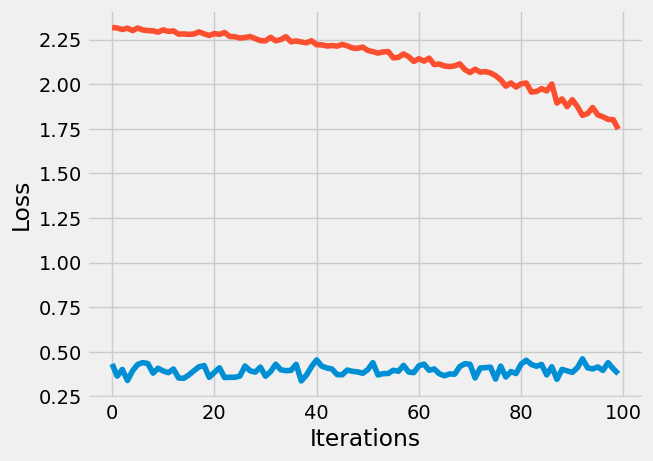

In [14]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.plot(losses[:100])

In [15]:
img, _ = VAE.sample(6)
plt.imshow(img.detach().reshape(28,28), cmap='pink')

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

In [16]:
VAE.generate_digits()

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

<Figure size 1400x1000 with 0 Axes>

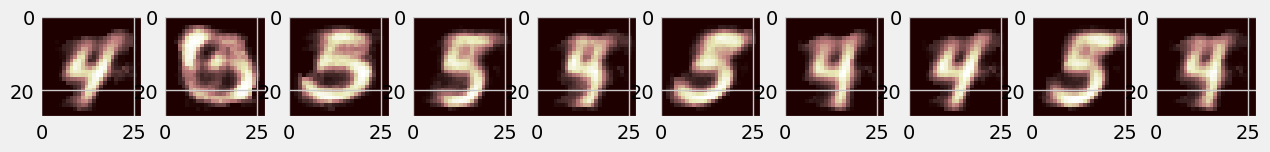

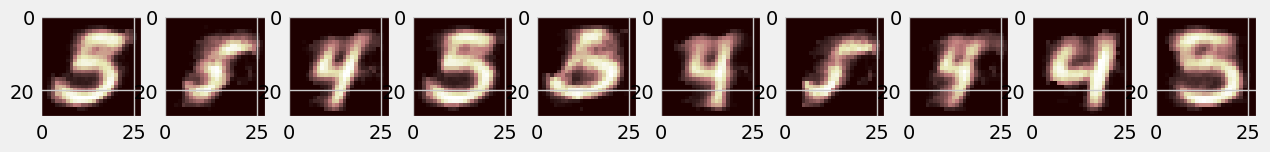

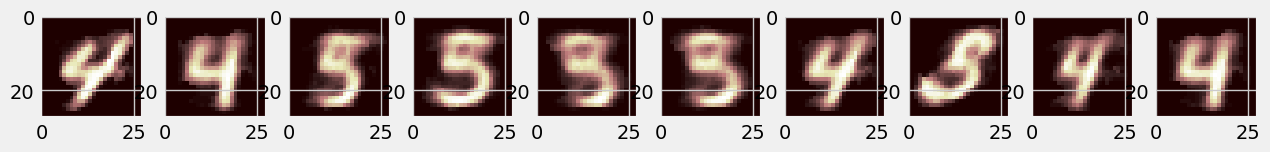

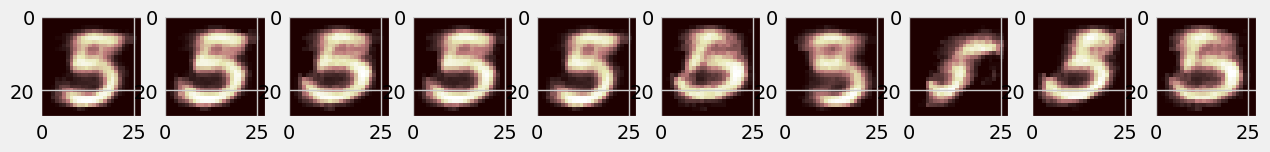

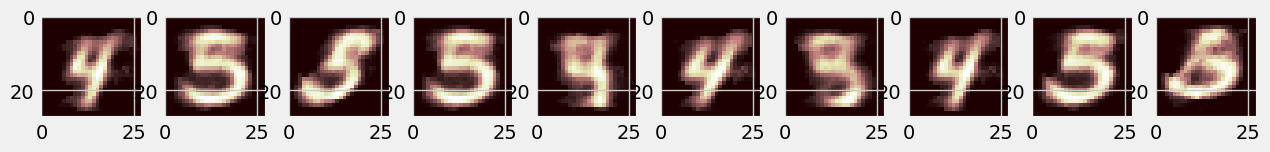

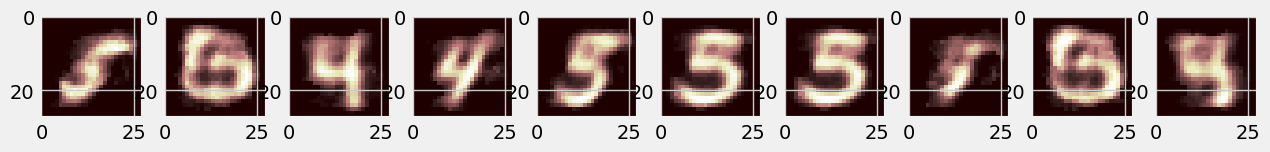

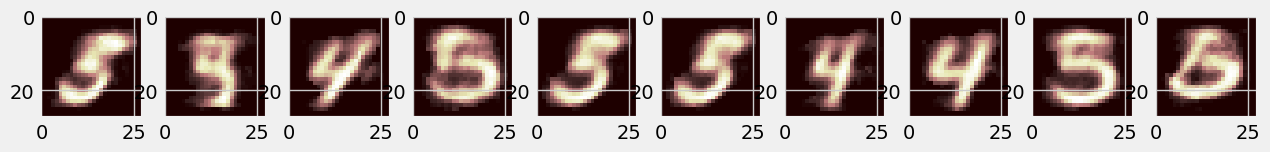

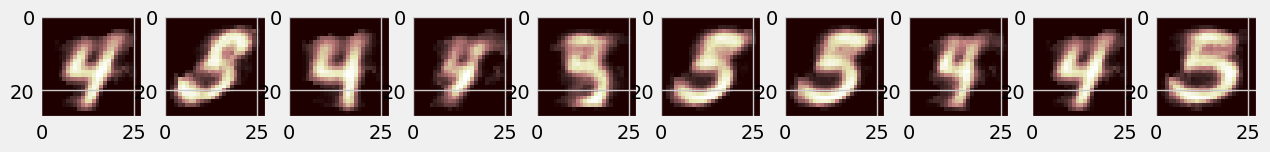

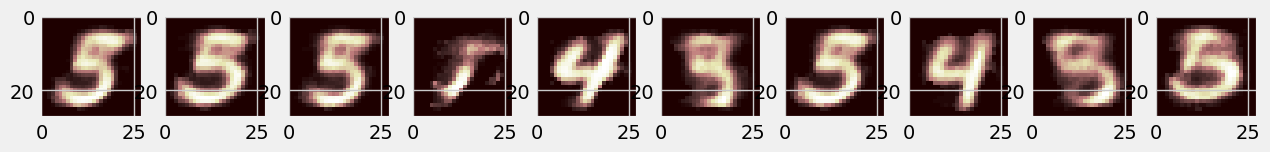

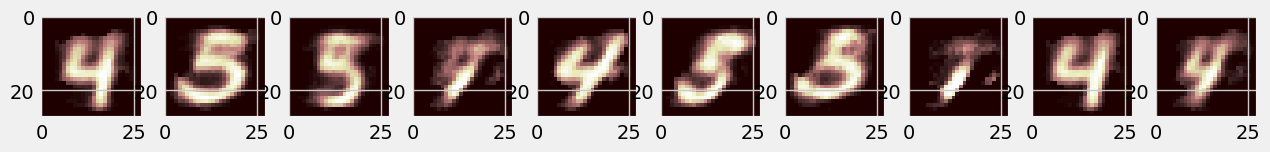

In [17]:
for j in range(10):
    fig = plt.figure(figsize=(14,10))
    with torch.no_grad():
        for i in range(10):
            z = torch.randn(2)
            y = torch.zeros(1)
            y[0] = 4
            z_cond = torch.cat((z,y))
            img = VAE.decoder(z_cond)
            ax = fig.add_subplot(1,10,i+1)
            ax.imshow(img.reshape(28,28), cmap='pink')
    plt.show()